In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor,HistGradientBoostingRegressor,ExtraTreesRegressor,RandomForestRegressor,BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
train_dataset = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
train_dataset.shape
train_dataset.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


# Explore dataset

In [3]:
train_dataset_drop = train_dataset.dropna()
train_dataset_drop.apply(lambda x: x.unique())

county                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
is_business                                                      [0, 1]
product_type                                               [1, 2, 3, 0]
target                [0.713, 96.59, 0.0, 17.314, 2.904, 656.859, 59...
is_consumption                                                   [0, 1]
datetime              [2021-09-01 00:00:00, 2021-09-01 01:00:00, 202...
data_block_id         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
row_id                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
prediction_unit_id    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
dtype: object

# Setup datetime

In [4]:
train_dataset_drop['datetime'] = pd.to_datetime(train_dataset_drop['datetime']).apply(lambda x: x.strftime('%Y-%m-%d'))
train_dataset_drop['hour'] = pd.to_datetime(train_dataset_drop['datetime']).dt.hour.astype(int)
train_dataset_drop['day'] = pd.to_datetime(train_dataset_drop['datetime']).dt.day.astype(int)
train_dataset_drop['month'] = pd.to_datetime(train_dataset_drop['datetime']).dt.month.astype(int)
train_dataset_drop['year'] = pd.to_datetime(train_dataset_drop['datetime']).dt.year.astype(int)

/tmp/ipykernel_47/1663964555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_drop['datetime'] = pd.to_datetime(train_dataset_drop['datetime']).apply(lambda x: x.strftime('%Y-%m-%d'))
/tmp/ipykernel_47/1663964555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_drop['hour'] = pd.to_datetime(train_dataset_drop['datetime']).dt.hour.astype(int)
/tmp/ipykernel_47/1663964555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [5]:
train_dataset_drop.head()
train_dataset_drop.shape
train_dataset_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017824 entries, 0 to 2018351
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
 9   hour                int64  
 10  day                 int64  
 11  month               int64  
 12  year                int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 215.5+ MB


# Preview Gas prices

In [6]:
gas_price_dataset = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv')
gas_price_dataset.shape

(637, 5)

In [7]:
gas_price_dataset.head()
gas_price_dataset = gas_price_dataset.rename(columns={'forecast_date':'datetime'})
gas_price_dataset = gas_price_dataset.drop(columns=['origin_date'])

In [8]:
gas_price_dataset

,datetime,lowest_price_per_mwh,highest_price_per_mwh,data_block_id
0,2021-09-01,45.23,46.32,1
1,2021-09-02,45.62,46.29,2
2,2021-09-03,45.85,46.40,3
3,2021-09-04,46.30,46.80,4
4,2021-09-05,46.30,46.58,5
...,...,...,...,...
632,2023-05-26,29.10,34.10,633
633,2023-05-27,28.30,34.10,634
634,2023-05-28,28.10,34.10,635
635,2023-05-29,28.16,36.98,636


In [9]:
gas_train_dataset = train_dataset_drop.merge(gas_price_dataset, on=['data_block_id'])
gas_train_dataset.head()

,county,is_business,product_type,target,is_consumption,datetime_x,data_block_id,row_id,prediction_unit_id,hour,day,month,year,datetime_y,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,1.687,0,2021-09-02,1,2928,0,0,2,9,2021,2021-09-01,45.23,46.32
1,0,0,1,109.366,1,2021-09-02,1,2929,0,0,2,9,2021,2021-09-01,45.23,46.32
2,0,0,2,0.000,0,2021-09-02,1,2930,1,0,2,9,2021,2021-09-01,45.23,46.32
3,0,0,2,21.008,1,2021-09-02,1,2931,1,0,2,9,2021,2021-09-01,45.23,46.32
4,0,0,3,1.003,0,2021-09-02,1,2932,2,0,2,9,2021,2021-09-01,45.23,46.32


# Organize features

In [10]:
features = ['county', 'product_type', 'is_business', 'is_consumption', 'hour', 'day', 'month', 'year', 
            'lowest_price_per_mwh', 'highest_price_per_mwh']

In [11]:
train_dataset_dummy = pd.get_dummies(gas_train_dataset[features + ['target']], columns=['product_type', 'is_business', 'is_consumption']).astype(float)
train_dataset_dummy.head()

,county,hour,day,month,year,lowest_price_per_mwh,highest_price_per_mwh,target,product_type_0,product_type_1,product_type_2,product_type_3,is_business_0,is_business_1,is_consumption_0,is_consumption_1
0,0.0,0.0,2.0,9.0,2021.0,45.23,46.32,1.687,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,2.0,9.0,2021.0,45.23,46.32,109.366,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,2.0,9.0,2021.0,45.23,46.32,0.000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,2.0,9.0,2021.0,45.23,46.32,21.008,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,2.0,9.0,2021.0,45.23,46.32,1.003,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


# Setup Parameters for Neural Network and Regression Model

In [12]:
train_dataset_drop = train_dataset.dropna()
X = train_dataset_dummy.drop(columns='target')
y = train_dataset_dummy.target

def deriv_mae(y_true, y_pred):
    return tf.reduce_mean(y_pred/tf.abs(y_pred - y_true))

def sae(y_true, y_pred):
    return tf.math.reduce_std(tf.abs(y_pred - y_true))

def mae(y_true, y_pred):
    return tf.math.reduce_mean(tf.abs(y_pred - y_true))

callbacks_list = [tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss',
                  restore_best_weights=True,
                  patience=5)] 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network and Test with MAE
### This code defines a simple feedforward neural network using the TensorFlow and Keras library for regression tasks. 

In [13]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=(input_shape,)),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0),
        # tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    
    model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mae', 'mse'])  # Adding mean squared error as an additional metric

    return model

# Assuming X_train and y_train are your training data
input_shape = X_train.shape[1]
model = create_model(input_shape)

# Training the model
history=model.fit(X_train, y_train,
          epochs=100, 
          batch_size=512,
          callbacks=callbacks_list,
          validation_data=(X_valid, y_valid))

Epoch 1/100
3149/3149 [==============================] - 11s 3ms/step - loss: 197.6832 - mae: 196.4654 - mse: 535369.6875 - val_loss: 153.9074 - val_mae: 151.1662 - val_mse: 220496.4844
Epoch 2/100
3149/3149 [==============================] - 9s 3ms/step - loss: 147.3388 - mae: 143.9758 - mse: 236576.8594 - val_loss: 131.4082 - val_mae: 127.7596 - val_mse: 186460.9219
Epoch 3/100
3149/3149 [==============================] - 8s 3ms/step - loss: 137.1088 - mae: 133.3618 - mse: 209274.2188 - val_loss: 119.2880 - val_mae: 115.4430 - val_mse: 147619.2656
Epoch 4/100
3149/3149 [==============================] - 8s 3ms/step - loss: 132.7464 - mae: 128.8620 - mse: 199844.0156 - val_loss: 125.0061 - val_mae: 121.1114 - val_mse: 160998.7031
Epoch 5/100
3149/3149 [==============================] - 9s 3ms/step - loss: 129.9528 - mae: 126.0255 - mse: 196129.8438 - val_loss: 113.1746 - val_mae: 109.2480 - val_mse: 138676.8281
Epoch 6/100
3149/3149 [==============================] - 8s 3ms/step - los

In [14]:
predsModel = (model.predict(X_valid))
mae = mean_absolute_error(y_valid, predsModel)
print(f"Neural Network, MAE: {mae}")

12594/12594 [==============================] - 16s 1ms/step
Neural Network, MAE: 103.97430635157988


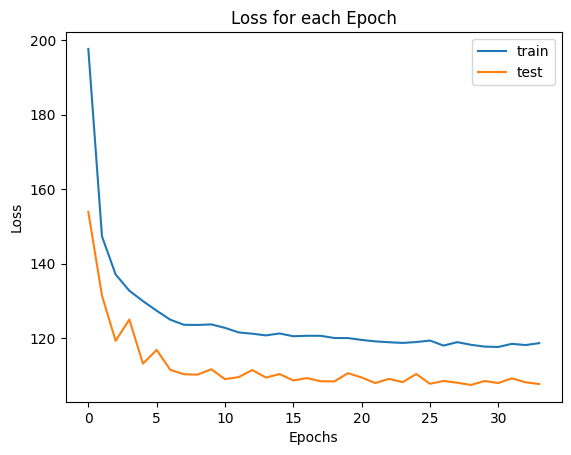

In [15]:
plt.title("Loss for each Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(list(range(0,len(history.history['loss']))),history.history['loss'], label='train')
plt.plot(list(range(0,len(history.history['val_loss']))),history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Running Multiple Regression Models to See the Best MAE

## CatBoostRegressor

In [16]:
cb_model = CatBoostRegressor()
cb_model.fit(X_train, y_train)

Learning rate set to 0.131504
0:	learn: 824.5063314	total: 285ms	remaining: 4m 44s
1:	learn: 745.7234175	total: 440ms	remaining: 3m 39s
2:	learn: 680.2839829	total: 590ms	remaining: 3m 16s
3:	learn: 632.9445764	total: 736ms	remaining: 3m 3s
4:	learn: 586.6282424	total: 885ms	remaining: 2m 56s
5:	learn: 554.9322550	total: 1.03s	remaining: 2m 50s
6:	learn: 527.2972334	total: 1.18s	remaining: 2m 47s
7:	learn: 505.8514352	total: 1.33s	remaining: 2m 44s
8:	learn: 483.1582410	total: 1.48s	remaining: 2m 42s
9:	learn: 469.0117923	total: 1.63s	remaining: 2m 41s
10:	learn: 453.4370440	total: 1.78s	remaining: 2m 39s
11:	learn: 444.4773081	total: 1.92s	remaining: 2m 38s
12:	learn: 437.4822861	total: 2.07s	remaining: 2m 37s
13:	learn: 431.9460558	total: 2.22s	remaining: 2m 36s
14:	learn: 427.3243622	total: 2.36s	remaining: 2m 35s
15:	learn: 423.4317893	total: 2.5s	remaining: 2m 33s
16:	learn: 420.4311702	total: 2.64s	remaining: 2m 32s
17:	learn: 417.0429703	total: 2.79s	remaining: 2m 32s
18:	learn:

In [17]:
#VotingRegressor,HistGradientBoostingRegressor,ExtraTreesRegressor,RandomForestRegressor,BaggingRegressor

preds = cb_model.predict(X_valid)
mae_valuescb = mean_absolute_error(preds, y_valid)
print(f"CatBoost, MAE: {mae_valuescb}")

CatBoost, MAE: 122.0149758140668


## ExtraTreesRegressor

In [18]:
et_model = ExtraTreesRegressor()
et_model.fit(X_train, y_train)

ExtraTreesRegressor()

In [19]:
predsExtra = (et_model.predict(X_valid))
mae_valuesExtra = mean_absolute_error(predsExtra, y_valid)
print(f"ExtraTreesRegressor, MAE: {mae_valuesExtra}")

mse_valuesExtra = np.mean((predsExtra - y_valid)**2)

print(f"Mean Squared Error (MSE): {mse_valuesExtra}")

r_squared = r2_score(y_valid, predsExtra)

# Assuming 'X_valid' is the feature matrix and 'n' is the number of data points
n = len(X_valid)
p = X_valid.shape[1]  # Number of predictors

# Calculate Adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print(f"Adjusted R-squared: {adjusted_r_squared}")

ExtraTreesRegressor, MAE: 97.75362105478982
Mean Squared Error (MSE): 84693.38771059595
Adjusted R-squared: 0.8973507044082553


## HistGradientBoostingRegressor

In [20]:
hist_model = HistGradientBoostingRegressor()
hist_model.fit(X_train, y_train)

HistGradientBoostingRegressor()

In [21]:
predsHist = (hist_model.predict(X_valid))
mae_valuesHist = mean_absolute_error(predsHist, y_valid)
print(f"HistGradientBoostingRegressor, MAE: {mae_valuesHist}")

HistGradientBoostingRegressor, MAE: 122.7647654141357


## KNeighborsRegressor

In [22]:
voting = KNeighborsRegressor()
voting.fit(X_train, y_train)

KNeighborsRegressor()

In [23]:
predsRandom = (voting.predict(X_valid))
mae_valuesvoting = mean_absolute_error(predsRandom, y_valid)
print(f"KNeighborsRegressor, MAE: {mae_valuesvoting}")

KNeighborsRegressor, MAE: 100.81070539133454
